# Inverse Analysis of Turbidites by Machine Learning Technique

# Preprocessing of training and test data sets

In [2]:
import numpy as np
import os
import ipdb

def connect_dataset(dist_start, dist_end, file_list, outputdir,
                    topodx=5, offset=5000,gclass_num=4,test_data_num=100):
    """
    Connect multiple raw data to produce the training and test data sets
    """
    
    # Define start and end points in the data sets
    prox =  np.round((dist_start+offset)/topodx).astype(np.int32)
    dist = np.round((dist_end+offset)/topodx).astype(np.int32)
    H = np.zeros([0,(dist-prox)* (gclass_num) ])
    icond = np.zeros([0,gclass_num + 3])
    
    # Read files and combine them
    for i in range(len(file_list)):
        print(file_list[i])
        H_temp = np.loadtxt(file_list[i] + '/H1.txt', delimiter = ',')[:,prox:dist]
        for j in range(2, gclass_num + 1):
            H_next = np.loadtxt(file_list[i] + '/H{}.txt'.format(j), delimiter = ',')[:,prox:dist]
            H_temp = np.concatenate([H_temp, H_next], axis = 1)
        icond_temp = np.loadtxt(file_list[i] + '/initial_conditions.txt', delimiter = ',')
        if icond_temp.shape[0] != H_temp.shape[0]:
            icond_temp = icond_temp[:-1,:]
        H = np.concatenate((H,H_temp),axis=0)
        icond = np.concatenate((icond,icond_temp),axis = 0)
    
    # Detect the maximum and minimum values in data sets
    max_x = np.max(H)
    min_x = np.min(H)
    icond_max = np.max(icond, axis=0)
    icond_min = np.min(icond, axis=0)
    
    # Split data for test and training sets
    H_train = H[0:-test_data_num,:]
    H_test = H[H.shape[0] - test_data_num:,:]
    icond_train = icond[0:-test_data_num,:]
    icond_test = icond[H.shape[0] - test_data_num:,:]
    
    # Save data sets
    if not os.path.exists(outputdir):
        os.mkdir(outputdir)
    np.save(os.path.join(outputdir, 'H_train.npy'), H_train)
    np.save(os.path.join(outputdir, 'H_test.npy'),H_test)
    np.save(os.path.join(outputdir, 'icond_train.npy'),icond_train)
    np.save(os.path.join(outputdir, 'icond_test.npy'),icond_test)
    np.save(os.path.join(outputdir, 'icond_min.npy'),icond_min)
    np.save(os.path.join(outputdir, 'icond_max.npy'),icond_max)
    np.save(os.path.join(outputdir, 'x_minmax.npy'),[min_x, max_x])
    
if __name__=="__main__":

    # dist_end = 30000
    # original_data_dir = "/home/naruse/public/naruse/TC_training_data_4"
    original_data_dir = "/home/naruse/public/naruse/TC_training_data_4_slope"
    # parent_dir = "/home/naruse/antidune/Documents/PythonScripts/DeepLearningTurbidite/20201018_30km"
    parent_prefix = "/home/naruse/public/naruse/DeepLearningTurbidite/longslope"
    if not os.path.exists(parent_prefix):
        os.mkdir(parent_prefix)
    
    output_dir = []
    
    test_distance = [30.0]
    dist_start = [0.0]
    offset=10.0
    # test_distance = [95]
    for i in range(len(test_distance)):
        parent_dir = os.path.join(parent_prefix, str(test_distance[i]))
        if not os.path.exists(parent_dir):
            os.mkdir(parent_dir)
        output_dir.append(os.path.join(parent_dir, "data"))
    
    file_list = []
    for j in range(1,6):
        dirname = os.path.join(original_data_dir, "TCModel_for_ML{0:02d}s".format(j), "output")
        if os.path.exists(dirname):
            file_list.append(dirname)
    # connect_dataset(dist_start, dist_end, file_list, outputdir, test_data_num=300)

    for k in range(len(test_distance)):
        connect_dataset(dist_start[0] * 1000, (test_distance[k] + dist_start[0]) * 1000,
                        file_list, output_dir[k], test_data_num=35, offset=offset * 1000)        
        
    

/home/naruse/public/naruse/TC_training_data_4_slope/TCModel_for_ML01s/output
/home/naruse/public/naruse/TC_training_data_4_slope/TCModel_for_ML02s/output
/home/naruse/public/naruse/TC_training_data_4_slope/TCModel_for_ML03s/output
/home/naruse/public/naruse/TC_training_data_4_slope/TCModel_for_ML04s/output
/home/naruse/public/naruse/TC_training_data_4_slope/TCModel_for_ML05s/output


# Common settings for plotting

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# settings for plotting
linewidth = 0.5
linestyle = ['-', '--', ':', '-.']
linecolor = ["r", "g", "b", "c", "m", "y", "k"]
lc_id = 0
params = {'legend.fontsize': 5,
          'legend.handlelength': 1.,
          'legend.frameon': False,
          'font.size' : 7,
          'font.family': ['sans-serif'],
          'font.sans-serif': ['Arial'],
          'legend.labelspacing' : 0.5,
          'legend.handletextpad' : 0.5,
          'legend.markerscale' : 1.,
         }
plt.rcParams.update(params)


# Check basic properties of training data sets

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

thick_file = '/home/naruse/public/naruse/DeepLearningTurbidite/fulldata/95/data/H_test.npy'
gclass_num = 4
dx = 5.0
gclass_value = np.array([1.5, 2.5, 3.5, 4.5])
gclass_name = []
for i in range(gclass_num):
    gclass_name.append('{}$\phi$'.format(gclass_value[i]))
H_test = np.load(thick_file) # data sets for values of volume-per-unit-area of all grain size classes
num_grids = int(H_test.shape[1]/gclass_num)
num_data = H_test.shape[0]

# split data sets for every grain size classes
volume_unit_area = np.empty([gclass_num, num_data,  num_grids]) # array for volume-per-unit-area for each grain size classes

for i in range(gclass_num):
    volume_unit_area[i, :, :] = H_test[:,i*num_grids:(i+1)*num_grids]

thickness = np.sum(volume_unit_area, axis=0) # total thickness

Mean of maximum thickness of beds: 1.2715092481333332 m
Standard deviation of maximum thickness of beds: 1.6545673324702501 m
Mean of maximum reach of bed (> 1cm): 41976.46666666667
Standard deviation of maximum reach of bed (> 1cm): 15697.077168089567


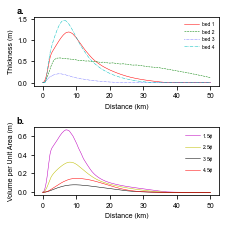

In [3]:
# Calculate longitudinal variation of mean grain size
mean_grain_size = np.zeros([num_data, num_grids])
significant_thick = np.where(thickness > 0.01)
for i in range(gclass_num):
    mean_grain_size[significant_thick] += gclass_value[i] * volume_unit_area[i][significant_thick]
mean_grain_size[significant_thick] /= thickness[significant_thick]

# Calculate mean and standard deviation of thickness and maximum reach of beds
mean_max_thick = np.average(np.max(thickness, axis=1))
std_max_thick = np.std(np.max(thickness, axis=1), ddof=1)
x = np.tile(np.arange(0, num_grids * dx, dx), num_data).reshape(num_data, num_grids)
x[thickness < 0.01] = 0
mean_max_reach = np.average(np.max(x, axis=1))
std_max_reach = np.std(np.max(x, axis=1), ddof=1)

print('Mean of maximum thickness of beds: {} m'.format(mean_max_thick))
print('Standard deviation of maximum thickness of beds: {} m'.format(std_max_thick))
print('Mean of maximum reach of bed (> 1cm): {}'.format(mean_max_reach))
print('Standard deviation of maximum reach of bed (> 1cm): {}'.format(std_max_reach))

# plot data sets
xrange=np.array([0, 50000])
xrange_grid = (xrange / dx).astype(np.int32)
x = np.arange(xrange[0], xrange[1], dx)
start_id = 6
num_beds = 4

# settings for plotting
linewidth = 0.5
linestyle = ['-', '--', ':', '-.']
linecolor = ["r", "g", "b", "c", "m", "y", "k"]
lc_id = 0
params = {'legend.fontsize': 5,
          'legend.handlelength': 3,
          'legend.frameon': False,
          'font.size' : 7,
          'font.family': ['sans-serif'],
          'font.sans-serif': ['Arial'],
         }
plt.rcParams.update(params)

# Plot results
fig, ax = plt.subplots(2, 1, figsize=(8/2.54,8/2.54))
plt.subplots_adjust(bottom=0.3, wspace=0.4)
for i in range(start_id, start_id + num_beds):
    ax[0].plot(x / 1000, thickness[i,xrange_grid[0]:xrange_grid[1]],
               lw=linewidth, linestyle=linestyle[(i - start_id)%4],
               color=linecolor[lc_id%7], label='bed {}'.format(i - start_id + 1))
    lc_id += 1
ax[0].set_xlabel('Distance (km)', fontsize=7)
ax[0].set_ylabel('Thickness (m)', fontsize=7)
ax[0].legend()
ylim = ax[0].get_ylim()
xlim = ax[0].get_xlim()
ax[0].text(xlim[0] - 0.1 * xlim[1], ylim[0] + (ylim[1] - ylim[0])*1.05, 'a.', fontweight='bold', fontsize=9)

# for k in range(start_id, start_id + num_beds):
#     ax[0,1].plot(x, mean_grain_size[k, xrange_grid[0]:xrange_grid[1]],label='bed{}'.format(k))
# ax[0,1].legend()
# ax[0,1].set_ylim([1.5, 4.5])

# for j in range(gclass_num):
for j in range(gclass_num):
    ax[1].plot(x / 1000, volume_unit_area[j, start_id, xrange_grid[0]:xrange_grid[1]],
               lw=linewidth, color=linecolor[lc_id%7], label=gclass_name[j])
    lc_id += 1
ax[1].set_xlabel('Distance (km)', fontsize=7)
ax[1].set_ylabel('Volume per Unit Area (m)', fontsize=7)
# ax[1].set_xlim(0,)
# ax[1].set_ylim(0,)
ax[1].legend()
ylim = ax[1].get_ylim()
xlim = ax[1].get_xlim()
ax[1].text(xlim[0] - 0.1 * xlim[1], ylim[0] + (ylim[1] - ylim[0])*1.05, 'b.', fontweight='bold', fontsize=9)

# for j in range(gclass_num):
#     ax[1,1].plot(x, volume_unit_area[j, start_id + 1, xrange_grid[0]:xrange_grid[1]],label=gclass_name[j])
# ax[1,1].legend()
#plt.tight_layout()
plt.tight_layout()
plt.savefig('tex/fig04.eps')
plt.show()

# Show training results depending on number of training data sets and length of sampling window

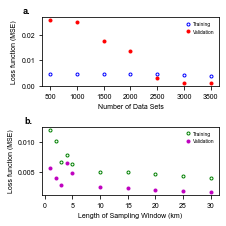

In [4]:
import os
from os.path import join
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

datadir = '/home/naruse/public/naruse/DeepLearningTurbidite/distance'
resdir_train_num = '/home/naruse/public/naruse/DeepLearningTurbidite/result_training_num_10'
resdir_distance = '/home/naruse/public/naruse/DeepLearningTurbidite/result_distance_3500'
base_distance = 10
base_train_num = 3500
case_train_num = [500, 1000, 1500, 2000, 2500, 3000, 3500]
case_distance = [1, 2, 3, 4, 5, 10, 15, 20, 25, 30]

# settings for plotting
linewidth = 0.5
linestyle = ['-', '--', ':', '-.']
linecolor = ["r", "g", "b", "c", "m", "y", "k"]
lc_id = 0
params = {'legend.fontsize': 5,
          'legend.handlelength': 1.,
          'legend.frameon': False,
          'font.size' : 7,
          'font.family': ['sans-serif'],
          'font.sans-serif': ['Arial'],
          'legend.labelspacing' : 0.5,
          'legend.handletextpad' : 0.5,
          'legend.markerscale' : 1.,
         }
plt.rcParams.update(params)

# Plot results
fig, ax = plt.subplots(2, 1, figsize=(8/2.54,8/2.54))
plt.subplots_adjust(bottom=0.3, wspace=0.5)

# Plot results depending on number of training data sets
loss_train_num = []
val_loss_train_num = []
for train_num in case_train_num:
    loss_train_num.append(
        np.loadtxt(join(resdir_train_num, '{}'.format(train_num),
                        'loss.txt'), delimiter=',')[-1])
    val_loss_train_num.append(
        np.loadtxt(join(resdir_train_num, '{}'.format(train_num),
                        'val_loss.txt'), delimiter=',')[-1])
ax[0].plot(case_train_num, loss_train_num, 'bo', markerfacecolor='w',
                label='Training', markersize=3)
ax[0].plot(case_train_num, val_loss_train_num, 'ro', markerfacecolor='r',
                label='Validation', markersize=3)
ax[0].set_xlabel('Number of Data Sets', fontsize=7)
ax[0].set_ylabel('Loss function (MSE)', fontsize=7)
ax[0].legend()
ylim = ax[0].get_ylim()
xlim = ax[0].get_xlim()
ax[0].text(xlim[0] - 0.1 * xlim[1], ylim[0] + (ylim[1] - ylim[0])*1.05, 'a.', fontweight='bold', fontsize=9)

# Plot results depending on lengths of sampling window
loss_distance = []
val_loss_distance = []
for distance in case_distance:
    loss_distance.append(
        np.loadtxt(join(resdir_distance, '{}'.format(distance),
                        'loss.txt'), delimiter=',')[-1])
    val_loss_distance.append(
        np.loadtxt(join(resdir_distance, '{}'.format(distance),
                        'val_loss.txt'), delimiter=',')[-1])
ax[1].plot(case_distance, loss_distance, 'go', markerfacecolor='w',
                label='Training', markersize=3)
ax[1].plot(case_distance, val_loss_distance, 'mo', markerfacecolor='m',
                label='Validation', markersize=3)
ax[1].set_xlabel('Length of Sampling Window (km)', fontsize=7)
ax[1].set_ylabel('Loss function (MSE)', fontsize=7)
ax[1].legend()
ylim = ax[1].get_ylim()
xlim = ax[1].get_xlim()
ax[1].text(xlim[0] - 0.1 * xlim[1], ylim[0] + (ylim[1] - ylim[0])*1.05, 'b.', fontweight='bold', fontsize=9)

# Save figures
plt.tight_layout()
plt.savefig('tex/fig05.eps')



# Show test results

\begin{tabular}{lrrrrrrr}
\toprule
{} &  R\textasciicircum 2 &  RMSE &  RMSE (normalized) &   MAE &  MAE (normalized) &  Mean bias &  Mean bias (normalized) \\
\midrule
Initial height & 0.99 & 18.97 &               8.55 & 14.81 &              5.96 &     -12.93 &                   -5.18 \\
Initial length & 0.99 & 15.82 &               7.53 & 12.09 &              4.92 &      -2.33 &                   -2.06 \\
C\_1            & 0.99 &  0.02 &              12.91 &  0.02 &              6.00 &      -0.01 &                   -4.44 \\
C\_2            & 0.99 &  0.02 &              15.57 &  0.02 &              7.67 &      -0.01 &                   -4.29 \\
C\_3            & 0.99 &  0.02 &              13.03 &  0.02 &              6.39 &      -0.00 &                   -2.49 \\
C\_4            & 0.99 &  0.03 &              13.71 &  0.02 &              6.67 &      -0.01 &                   -4.21 \\
S\_l            & 0.98 &  0.03 &              19.56 &  0.03 &             11.67 &       0.03 &       

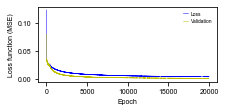

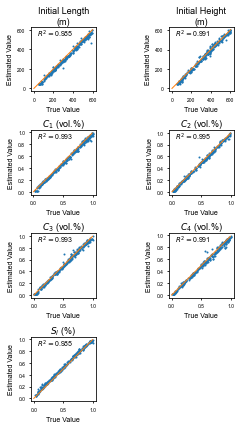

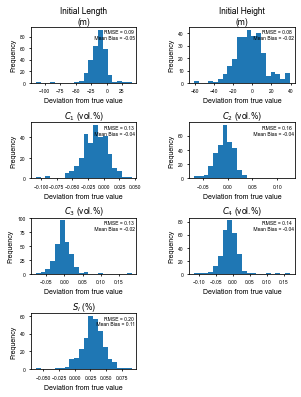

In [26]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from scipy import stats
from sklearn.utils import resample
import pandas as pd
%matplotlib inline

# datadir = '/home/naruse/antidune/Documents/PythonScripts/DeepLearningTurbidite/20180419/data/'
# resdir = '/home/naruse/antidune/Documents/PythonScripts/DeepLearningTurbidite/20180419/result_testGPU_4layers/2670/'
datadir = '/home/naruse/public/naruse/DeepLearningTurbidite/distance/10/data/'
resdir = '/home/naruse/public/naruse/DeepLearningTurbidite/result_training_num_10/3500/'

test_result = np.loadtxt(os.path.join(resdir, 'test_result.txt'),delimiter=',')
icond = np.load(os.path.join(datadir, 'icond_test.npy'))
loss = np.loadtxt(os.path.join(resdir, 'loss.txt'), delimiter=',')
vloss = np.loadtxt(os.path.join(resdir, 'val_loss.txt'), delimiter=',')
epoch = range(0,loss.shape[0])

# Calculate statistics
resi_ratio = (test_result - icond) / icond
resi = test_result - icond
r2value = []
for i in range(icond.shape[1]):
    r2value.append(r2_score(icond[:, i], test_result[:, i]))

mean_bias = np.average(resi,axis=0)
std_bias = np.std(resi,axis=0, ddof=1)
rmse = np.sqrt(np.sum(resi ** 2, axis=0) / resi.shape[0])
mae = np.sum(np.abs(resi), axis=0) / resi.shape[0]

mean_bias_ratio = np.average(resi_ratio,axis=0)
std_bias_ratio = np.std(resi_ratio,axis=0, ddof=1)
rmse_ratio = np.sqrt(np.sum(resi_ratio ** 2, axis=0) / resi_ratio.shape[0])
mae_ratio = np.sum(np.abs(resi_ratio), axis=0) / resi.shape[0]

# make a table for exhibiting statistics
df_stats = pd.DataFrame(
    {
        "R^2" : r2value,
        "RMSE" : rmse,
        "RMSE (normalized)" : rmse_ratio * 100,
        "MAE" : mae,
        "MAE (normalized)" : mae_ratio * 100,
        "Mean bias" : mean_bias,
        "Mean bias (normalized)" : mean_bias_ratio * 100,
    },
    index = [
        'Initial height',
        'Initial length',
        'C_1',
        'C_2',
        'C_3',
        'C_4',
        'S_l']
)
df_stats.loc['C_1':'S_l' ,['RMSE', 'MAE', 'Mean bias']] *= 100
print(df_stats.to_latex(float_format='%.2f'))


# Boostrap resampling
# n = 10000
# resampled_resi = np.empty(resi.shape)
# resampled_mean = np.zeros([n, resi.shape[1]])
# for i in range(resi.shape[1]):
#     for j in range(n):
#         resampled_resi[:,i] = resample(resi_ratio[:,i])
#         resampled_mean[j, i] = np.average(resampled_resi[:,i])

# Bootstrap mean and error range
# mean_bias_bootstrap = np.average(resampled_mean, axis=0)
# lowerbounds_bias_bootstrap = np.percentile(resampled_mean, 2.5, axis=0)
# upperbounds_bias_bootstrap = np.percentile(resampled_mean, 97.5, axis=0)

# settings for plotting
linewidth = 0.5
linestyle = ['-', '--', ':', '-.']
linecolor = ["r", "g", "b", "c", "m", "y", "k"]
lc_id = 0
params = {'legend.fontsize': 5,
          'legend.handlelength': 1.,
          'legend.frameon': False,
          'font.size' : 7,
          'font.family': ['sans-serif'],
          'font.sans-serif': ['Arial'],
          'legend.labelspacing' : 0.5,
          'legend.handletextpad' : 0.5,
          'legend.markerscale' : 1.,
         }
plt.rcParams.update(params)

# plot training history
fig, ax = plt.subplots(1,1, figsize=(8/2.54,4/2.54))
ax.plot(epoch, loss, 'b-',label='Loss', lw=0.5)
ax.plot(epoch, vloss, 'y-',label='Validation', lw=0.5)
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss function (MSE)')
ax.legend(loc="upper right")
plt.tight_layout()
plt.savefig('tex/fig06.eps')

print('Training loss: {}'.format(loss[-1]))
print('Validation loss: {}'.format(vloss[-1]))

hfont = {'fontname':'Century Gothic'}
textcol = 'k'
titlelabel = ['Initial Length\n(m)', 'Initial Height\n(m)',
              '$C_1$ (vol.%)', '$C_2$ (vol.%)', '$C_3$ (vol.%)', '$C_4$ (vol.%)', '$S_l$ (%)']
percent = [1, 1, 100, 100, 100, 100, 100]

# Scattered plots to compare the predicted values with the true values
fig2, ax2 = plt.subplots(int(len(titlelabel)/2) + 1, 2, figsize=(12/2.54, 17.5/2.54))
plt.subplots_adjust(wspace=0.1, hspace=0.6)
for i in range(len(titlelabel)):
    x_fig = int(i/2)
    y_fig = i%2          
    ax2[x_fig, y_fig].plot(icond[:,i] * percent[i],test_result[:,i] * percent[i],"o", markersize=1)
    ax2[x_fig, y_fig].plot([0,np.max(test_result[:,i] * percent[i])], [0, np.max(test_result[:,i]*percent[i])],
                           "-", lw=linewidth*2)
    ax2[x_fig, y_fig].set_xlabel('True Value',color=textcol,fontsize=7)
    ax2[x_fig, y_fig].set_ylabel('Estimated Value',color=textcol,fontsize=7)
    ax2[x_fig, y_fig].set_title(titlelabel[i],color=textcol,fontsize=9,pad=3.0)
    ax2[x_fig, y_fig].tick_params(colors=textcol,length=2,labelsize=5)
    ax2[x_fig, y_fig].set_aspect('equal')
    xlim = ax2[x_fig, y_fig].get_xlim()
    ylim = ax2[x_fig, y_fig].get_ylim()
    xloc = xlim[0] + (xlim[1] - xlim[0]) * 0.1
    yloc = ylim[0] + (ylim[1] - ylim[0]) * 0.85
    ax2[x_fig, y_fig].text(xloc, yloc, '$R^2 = ${:.3f}'.format(r2value[i]))
if len(titlelabel)%2 != 0: # remove unnecessary figure
    ax2[int(i/2), 1].remove()
# fig.tight_layout()
plt.savefig('tex/fig07.eps')
    #plt.show()

# Histograms for prediction errors
fig3, ax3 = plt.subplots(int(len(titlelabel)/2) + 1, 2, figsize=(12/2.54, 16/2.54))
plt.subplots_adjust(wspace=0.5, hspace=0.7)
for i in range(len(titlelabel)):
    x_fig = int(i/2)
    y_fig = i%2
    ax3[x_fig, y_fig].hist(resi[:,i] * percent[i],bins=20)
    ax3[x_fig, y_fig].set_title(titlelabel[i],color=textcol, pad=3.0)
    ax3[x_fig, y_fig].set_xlabel('Deviation from true value',color=textcol, fontsize=7)
    ax3[x_fig, y_fig].set_ylabel('Frequency',color=textcol, fontsize=7)
    ax3[x_fig, y_fig].tick_params(colors=textcol, length=2, labelsize=5)
    # xlim = ax3[x_fig, y_fig].get_xlim()
    # ylim = ax3[x_fig, y_fig].get_ylim()
    # xloc = xlim[0] + (xlim[1] - xlim[0]) * 0.1
    # yloc = ylim[0] + (ylim[1] - ylim[0]) * 0.7
    ax3[x_fig, y_fig].text(0.99, 0.95,
                'RMSE = {0:.2f} \n Mean Bias = {1:.2f}'.format(
                    rmse_ratio[i], mean_bias_ratio[i]),
                    # lowerbounds_bias_bootstrap[i] * 100,
                    # upperbounds_bias_bootstrap[i] * 100),
                           horizontalalignment='right', verticalalignment='top',
                           transform=ax3[x_fig, y_fig].transAxes, fontsize=5)
if len(titlelabel)%2 != 0: # remove unnecessary figure
    ax3[int(i/2), 1].remove()
fig.tight_layout()
plt.savefig('tex/fig08.eps')
    #plt.show()


# Check bias and errors of predicted values

mean bias
[-1.29266316e+01 -2.32764039e+00 -1.42043143e-04 -5.58904978e-05
 -3.05209377e-05 -9.54839696e-05  2.89349487e-04]
2σ of bias
[2.78196676e+01 3.13524848e+01 4.04460461e-04 4.01557574e-04
 4.80633580e-04 5.31698802e-04 3.78284572e-04]
RMSE
9.33717357851972
mean bias (ratio)
[-0.05178297 -0.02058269 -0.04440971 -0.0429332  -0.02491598 -0.04206466
  0.11448568]
2σ of bias (ratio)
[0.13624629 0.14501837 0.24293689 0.29978833 0.2562501  0.26138126
 0.31784317]
RMSE (ratio)
0.13519205042019936
p-values of the Shapiro-Wilk test for normality
7.849864286152072e-15
0.00040593656012788415
8.476071343466174e-06
2.2713582126243637e-09
5.597754790080678e-14
1.5576918959347638e-14
3.69856643374078e-05
mean bias (bootstrap samples)
[-0.05177063 -0.02051589 -0.04449836 -0.04274484 -0.02480929 -0.04208389
  0.11432631]
2.5 percentile of biases (bootstrap samples)
[-0.05933748 -0.02881048 -0.05900583 -0.06028632 -0.03990595 -0.05753963
  0.09736634]
97.5 percentile of biases (bootstrap samples

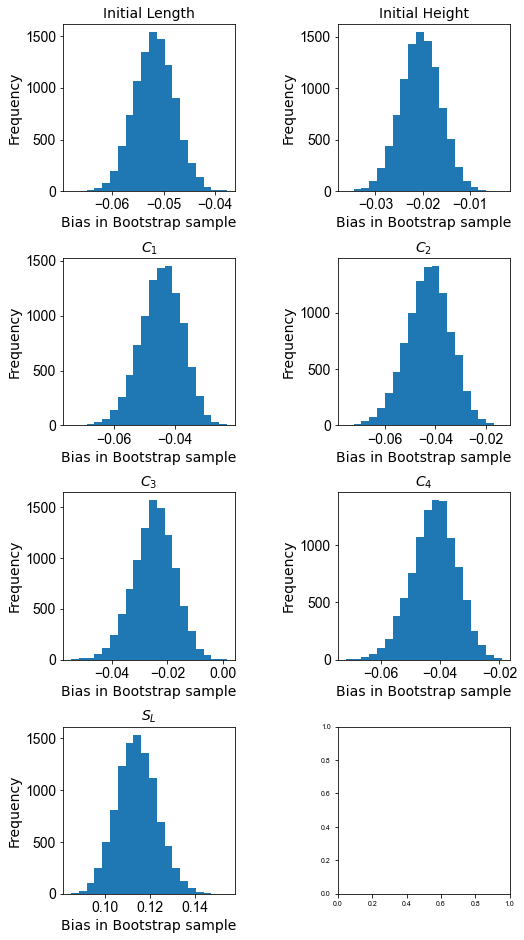

In [126]:
from scipy import stats
import numpy as np
from sklearn.utils import resample
import ipdb

resi_ratio = (test_result - icond) / icond
resi = test_result - icond

print("mean bias")
print(np.average(resi,axis=0))
print("2σ of bias")
print(np.std(resi,axis=0, ddof=1)*2)
print("RMSE")
print(np.sqrt(np.sum(resi**2)/resi.shape[0]/resi.shape[1]))

print("mean bias (ratio)")
print(np.average(resi_ratio,axis=0))
print("2σ of bias (ratio)")
print(np.std(resi_ratio,axis=0, ddof=1)*2)
print("RMSE (ratio)")
print(np.sqrt(np.sum(resi_ratio**2)/resi_ratio.shape[0]/resi_ratio.shape[1]))

print("p-values of the Shapiro-Wilk test for normality")
for i in range(resi.shape[1]):
    print(stats.shapiro(resi[:,i])[1])


# Bootstrap mean and error range
print("mean bias (bootstrap samples)")
print(np.average(resampled_mean, axis=0))
print("2.5 percentile of biases (bootstrap samples)")
print(np.percentile(resampled_mean, 2.5, axis=0))
print("97.5 percentile of biases (bootstrap samples)")
print(np.percentile(resampled_mean, 97.5, axis=0))

# Histograms of bootstrap samples
hfont = {'fontname':'Century Gothic'}
textcol = 'k'
titlelabel = ['Initial Length', 'Initial Height', '$C_1$', '$C_2$', '$C_3$', '$C_4$', '$S_L$']
fig4, ax4 = plt.subplots(int(len(titlelabel)/2) + 1, 2, figsize=(8, 4 * np.ceil(len(titlelabel) / 2)))
plt.subplots_adjust(wspace=0.6, hspace=0.4)
for i in range(len(titlelabel)):
    ax4[int(i/2), i%2].hist(resampled_mean[:,i],bins=20)
    ax4[int(i/2), i%2].set_title(titlelabel[i],color=textcol,size=14,**hfont)
    ax4[int(i/2), i%2].set_xlabel('Bias in Bootstrap sample',color=textcol,size=14,**hfont)
    ax4[int(i/2), i%2].set_ylabel('Frequency',color=textcol,size=14,**hfont)
    ax4[int(i/2), i%2].tick_params(labelsize=14,colors=textcol)
fig.tight_layout()
plt.savefig('hist_bootstrap.pdf')



# Compare time evolution of reconstructed parameters with original ones

Using matplotlib backend: agg
Reconstructed values: [4.5467e+02 3.0173e+02 1.7977e-03 1.5926e-04 9.2914e-03 7.2649e-03
 2.5254e-03]
True values: [4.8441e+02 3.1818e+02 1.6565e-03 5.4632e-04 9.5318e-03 7.4443e-03
 2.2881e-03]
RMSE: 0.27454715314370537
\begin{tabular}{lrrrrrrr}
\toprule
{} &  Initial height (m) &  Initial length (m) &  C\_1 (vol.\%) &  C\_2 (vol.\%) &  C\_3 (vol.\%) &  C\_4 (vol.\%) &  S\_l (\%) \\
\midrule
True input parameters &              484.41 &              318.18 &         0.17 &         0.05 &         0.95 &         0.74 &     0.23 \\
Estimated parameters  &              454.67 &              301.73 &         0.18 &         0.02 &         0.93 &         0.73 &     0.25 \\
\bottomrule
\end{tabular}



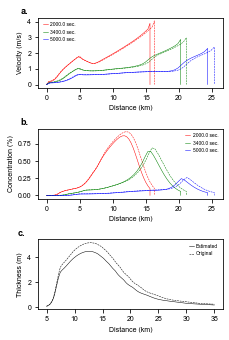

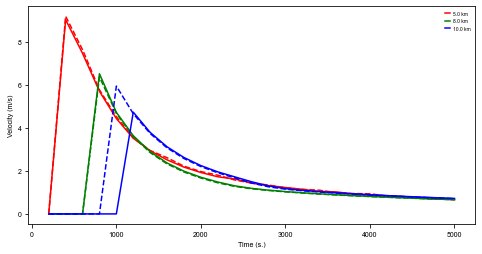

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from os.path import join
from os import mkdir
from scipy.interpolate import interp1d
import pandas as pd
%matplotlib

original_dir = '/home/naruse/antidune/Documents/MATLAB/TCtrainData_forML/TCModel_for_MLTEST/test_output_original5'
estimated_dir = '/home/naruse/antidune/Documents/MATLAB/TCtrainData_forML/TCModel_for_MLTEST/test_output_reconst5'
dist_offset = 5000.
dist_max = 30000.
topodx = 5
grid_origin = int(dist_offset / topodx)
grid_end = int((dist_max + dist_offset)/topodx)
snapshot_time = np.array([2000, 3500, 5000])
time_interval = 200.
time_frame = (snapshot_time / time_interval).astype(np.int64)

icond_estimated = np.loadtxt(join(estimated_dir, 'icond.txt'),delimiter=',')
Ht_estimated = np.loadtxt(join(estimated_dir, 'Ht.txt'),delimiter=',')
Ct_estimated = np.loadtxt(join(estimated_dir, 'Ct.txt'),delimiter=',')
U_estimated = np.loadtxt(join(estimated_dir, 'U.txt'),delimiter=',')
x_estimated = np.loadtxt(join(estimated_dir, 'x.txt'),delimiter=',')
x_bed = np.loadtxt(join(estimated_dir, 'x_init.txt'),delimiter=',')
time_estimated = np.loadtxt(join(estimated_dir, 'time.txt'),delimiter=',') 

icond_original = np.loadtxt(join(original_dir, 'icond.txt'),delimiter=',')
Ht_original = np.loadtxt(join(original_dir, 'Ht.txt'),delimiter=',')
Ct_original = np.loadtxt(join(original_dir, 'Ct.txt'),delimiter=',')
U_original = np.loadtxt(join(original_dir, 'U.txt'),delimiter=',')
x_original = np.loadtxt(join(original_dir, 'x.txt'),delimiter=',')
time_original = np.loadtxt(join(original_dir, 'time.txt'),delimiter=',')


print('Reconstructed values: {}'.format(icond_estimated))
print('True values: {}'.format(icond_original))
print('RMSE: {}'.format(np.sqrt(np.sum(((icond_estimated - icond_original)/icond_original)**2)/icond_estimated.shape[0])))

# Make a table to exhibit true and predicted values of model input parameters
df = pd.DataFrame(np.array([[icond_original[:]], [icond_estimated[:]]]).reshape(2, 7),
                  columns=[
                      'Initial height (m)',
                      'Initial length (m)',
                      'C_1 (vol.%)',
                      'C_2 (vol.%)',
                      'C_3 (vol.%)',
                      'C_4 (vol.%)',
                      'S_l (%)'
                  ],
                 index=[
                     'True input parameters',
                     'Estimated parameters'
                 ])
df.loc[:, 'C_1 (vol.%)':'S_l (%)'] *= 100
print(df.to_latex(float_format='%.2f'))


# settings for plotting
linewidth = 0.5
linestyle = ['-', '--', ':', '-.']
linecolor = ["r", "g", "b", "c", "m", "y", "k"]
lc_id = 0
params = {'legend.fontsize': 5,
          'legend.handlelength': 1.,
          'legend.frameon': False,
          'font.size' : 7,
          'font.family': ['sans-serif'],
          'font.sans-serif': ['Arial'],
          'legend.labelspacing' : 0.5,
          'legend.handletextpad' : 0.5,
          'legend.markerscale' : 1.,
         }
plt.rcParams.update(params)

# Plot results
fig1, ax1 = plt.subplots(3, 1, figsize=(8/2.54, 12/2.54))
plt.subplots_adjust(bottom=0.3, wspace=0.5)

# plot flow velocity
for tframe, col in zip(time_frame, linecolor):
    ax1[0].plot(x_estimated[tframe,:]/1000, U_estimated[tframe,:],
             '-', color=col, lw=linewidth, label='{} sec.'.format(tframe*time_interval))
    ax1[0].plot(x_original[tframe,:]/1000, U_original[tframe,:],'--',
             color=col, lw=linewidth, label=None)
# ax1[0].set_title('Flow Velocity', fontsize=9)
ax1[0].set_xlabel('Distance (km)', fontsize = 7)
ax1[0].set_ylabel('Velocity (m/s)', fontsize = 7)
ax1[0].legend()
xlim = ax1[0].get_xlim()
ylim = ax1[0].get_ylim()
ax1[0].text(xlim[0] - 0.1 * xlim[1], ylim[0] + (ylim[1] - ylim[0])*1.05, 'a.', fontweight='bold', fontsize=9)

# plot sediment concentration
for tframe, col in zip(time_frame, linecolor):
    ax1[1].plot(x_estimated[tframe,:]/1000, Ct_estimated[tframe,:] * 100, '-',
             color=col, lw=linewidth, label='{} sec.'.format(tframe*time_interval))
    ax1[1].plot(x_original[tframe,:]/1000, Ct_original[tframe,:] * 100, '--',
             color=col, lw=linewidth, label=None)
# ax1[1].set_title('Total Concentration', fontsize = 9)
ax1[1].set_xlabel('Distance (km)', fontsize = 7)
ax1[1].set_ylabel('Concentration (%)', fontsize = 7)
ax1[1].legend()
xlim = ax1[1].get_xlim()
ylim = ax1[1].get_ylim()
ax1[1].text(xlim[0] - 0.1 * xlim[1], ylim[0] + (ylim[1] - ylim[0])*1.05, 'b.', fontweight='bold', fontsize=9)

# plot thickness 
ax1[2].plot(x_bed[grid_origin:grid_end]/1000, Ht_estimated[-1,grid_origin:grid_end],'k-',
         lw=linewidth, label='Estimated')
ax1[2].plot(x_bed[grid_origin:grid_end]/1000, Ht_original[-1,grid_origin:grid_end],'k--',
         lw=linewidth, label='Original')
# ax1[2].set_title('Bed thickness', size = 9, **hfont)
ax1[2].set_xlabel('Distance (km)', fontsize = 7)
ax1[2].set_ylabel('Thickness (m)', fontsize = 7)
xlim = ax1[2].get_xlim()
ylim = ax1[2].get_ylim()
ax1[2].legend()
ax1[2].text(xlim[0] - 0.1 * xlim[1], ylim[0] + (ylim[1] - ylim[0])*1.05, 'c.', fontweight='bold', fontsize=9)

# save figure
plt.tight_layout()
plt.savefig('tex/fig09.eps')

# Time evolution at fixed location
start = 0.0
endtime = 5000.0
start_d = int(start / time_interval)
endtime_d = int(endtime / time_interval)

outcrop = np.array([5*1000, 8 * 1000, 10 * 1000])
linecolor = ['r', 'g', 'b']

U_original_loc = np.zeros([len(time_original),len(outcrop)])
U_estimated_loc = np.zeros([len(time_original),len(outcrop)])
if len(time_original) > len(time_estimated):
    time_length = len(time_estimated)
else:
    time_length = len(time_original)

for j in range(time_length):
    f_original = interp1d(x_original[j,:], U_original[j,:], kind="linear", bounds_error=False, fill_value=0)
    U_original_loc[j,:] = f_original(outcrop)
    f_estimated = interp1d(x_estimated[j,:], U_estimated[j,:], kind="linear", bounds_error=False, fill_value=0)
    U_estimated_loc[j,:] = f_estimated(outcrop)

#図にプロットする
fig2, ax2 = plt.subplots(1, 1, figsize=(8, 4))
plt.subplots_adjust(wspace=0.6, hspace=0.4)
for k in range(len(outcrop)):
    ax2.plot(time_original[start_d:endtime_d], U_original_loc[start_d:endtime_d,k], '--',
             color= linecolor[k], label=None)
    ax2.plot(time_estimated[start_d:endtime_d], U_estimated_loc[start_d:endtime_d,k], '-',
             color= linecolor[k], label='{} km'.format(outcrop[k] / 1000))
ax2.legend()
ax2.set_xlabel('Time (s.)')
ax2.set_ylabel('Velocity (m/s)')
# ax2.set_title('Velocity')
plt.savefig('compare_result_fixedloc.svg')




# tests with normal random numbers

In [58]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from scipy import stats
from scipy.stats import sem
import os
%matplotlib inline

def check_noise(model=None,
                X_test=None,
                y_test=None,
                y_min=None,
                y_max=None,
                min_x=None,
                max_x=None,
                err_rate=0.10,
                datadir = None,
                resdir = None,
                gclass = 4,
                topodx = 5,
                plot_fig = True,
                ):
    
    # Obtain the original data sets
    if X_test is None: X_test = np.load(os.path.join(datadir, 'H_test.npy'))
    if y_test is None: y_test = np.load(os.path.join(datadir, 'icond_test.npy'))
    if y_min is None: y_min = np.load(os.path.join(datadir, 'icond_min.npy'))
    if y_max is None: y_max = np.load(os.path.join(datadir, 'icond_max.npy'))

    
    # normalization
    if min_x is None or max_x is None: min_x, max_x = np.load(os.path.join(datadir, 'x_minmax.npy'))
    X_test_norm =  (X_test - min_x) / (max_x - min_x)

    # add noise
    # 2 sigma = true parameter times err_rate
    err = np.random.normal(size=X_test_norm.shape)
    x_test_norm_w_error = X_test_norm + err * 0.5 * err_rate * X_test_norm
    num_node_per_gclass = int(X_test_norm.shape[1] / gclass)
    dist = np.arange(0,num_node_per_gclass)* topodx
    

    #print(X_test_norm[1,1000:1010])
    #print(x_test_norm_w_error[1,1000:1010])
    #print(err[1,1000:1010])

    # load the model if the model is None
    # model = load_model(resdir+'model.hdf5')
    test_result = model.predict(X_test_norm)
    test_result = test_result * (y_max - y_min) + y_min
    test_result_w_error = model.predict(x_test_norm_w_error)
    test_result_w_error = test_result_w_error * (y_max - y_min) + y_min

    # Load true parameters
    icond = np.load(os.path.join(datadir, 'icond_test.npy'))
    loss = np.loadtxt(os.path.join(resdir, 'loss.txt'), delimiter=',')
    epoch = range(0,len(loss))
    vloss = np.loadtxt(resdir+'val_loss.txt',delimiter=',')
    
    # Calculate residuals
    resi = (test_result - icond)
    resi_w_error = (test_result_w_error - icond)
    resi_w_error_ratio = (test_result_w_error - icond) / icond

    # Plot figure of each test
    if plot_fig:
        plt.figure()
        plt.plot(x_test_norm_w_error[1,0:num_node_per_gclass], label='With Error')
        plt.plot(X_test_norm[1,0:num_node_per_gclass], label='Original')
        plt.xlabel('Distance')
        plt.ylabel('Normalized thickness')
        plt.legend()

    
        titlelabel = ['Initial Length', 'Initial Height', '$C_1$', '$C_2$', '$C_3$', '$C_4$', '$S_1$']
        hfont = {'fontname':'Century Gothic'}
        textcol = 'k'
    
        for i in range(len(titlelabel)):
            plt.figure()
            plt.plot(icond[:,i],test_result[:,i],"bo",label='without error')
            plt.plot(icond[:,i],test_result_w_error[:,i],"ro",label='with error ({:.0f}%)'.format(err_rate*100))
            plt.title(titlelabel[i],color=textcol,size=14,**hfont)
            plt.xlabel('True values',color=textcol,size=14,**hfont)
            plt.ylabel('Estimated values',color=textcol,size=14,**hfont)
            plt.legend()
            plt.tick_params(labelsize=14,colors=textcol)
            plt.savefig(titlelabel[i] + 'err{:.0f}'.format(err_rate*100) + '.pdf')
            #plt.show()

        for i in range(len(titlelabel)):
            plt.figure()
            plt.hist(resi_w_error[:,i],bins=20)
            plt.title(titlelabel[i])
            plt.xlabel('Deviation from true value')
            plt.ylabel('Frequency')
            #plt.show()

#        print("Mean Square error")
#        print(np.average(resi**2,axis=0))
#        print("MSE with noise")
#        print(np.average(resi_w_error**2,axis=0))
#        print("Mean error")
#        print(np.average(resi,axis=0))
#        print("Mean error with noise)
#        print(np.average(resi_w_error,axis=0))
#        print("2 sigma of residuals")
#        print(np.std(resi,axis=0)*2)
#        print("2 sigma of residuals with noise")
#        print(np.std(resi_w_error,axis=0)*2)
#        print("ratio of residuals to true value")
#        print(np.average(np.abs(resi)/icond,axis=0))
#        print("ratio of residuals to true value with noise")
#        print(np.average(np.abs(resi_w_error)/icond,axis=0))
#        print("p-values of the Shapiro-Wilk test for normality")
#        for i in range(resi.shape[1]):
 #           print(stats.shapiro(resi[:,i])[1])
 #           print("p-values of the Shapiro-Wilk test for normality (with error)")
 #       for i in range(resi_w_error.shape[1]):
 #           print(stats.shapiro(resi_w_error[:,i])[1])
    
    # Return normalized RMSE
    RMS = np.sqrt(np.sum(resi_w_error_ratio ** 2) / resi_w_error_ratio.shape[0] / resi_w_error_ratio.shape[1])
    
    return RMS
    
if __name__ == "__main__":
    datadir = '/home/naruse/public/naruse/DeepLearningTurbidite/distance/10/data/'
    resdir = '/home/naruse/public/naruse/DeepLearningTurbidite/result_training_num_10/3500/'
    model = load_model(os.path.join(resdir, 'model.hdf5'))
    
    noisetest_err_rate = np.linspace(0,2.0,40)
    result_noise = np.zeros(len(noisetest_err_rate))
    result_noise_stderr = np.zeros(len(noisetest_err_rate))
    num_tests = 20
    for i in range(len(noisetest_err_rate)):
        testres = np.zeros([num_tests])
        for j in range(num_tests):
            testres[j] = check_noise(model, datadir=datadir, resdir=resdir, err_rate=noisetest_err_rate[i], plot_fig=False)
        result_noise[i] = np.average(testres)
        result_noise_stderr[i] = sem(testres)
        
    np.savetxt("result_w_error.csv",result_noise,delimiter=',')
    
   

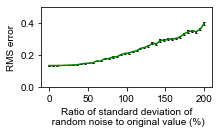

In [60]:
%matplotlib inline

# plot result of noise tests

fig1, ax1 = plt.subplots(1, 1, figsize=(8/2.54, 5/2.54))
plt.subplots_adjust(bottom=0.3, wspace=0.5, hspace=0.3)

ax1.errorbar(noisetest_err_rate*100, result_noise, color='g', yerr=result_noise_stderr, ecolor='k', capsize=1.)
# ax1.title("$S_L$")
ax1.set_xlabel('Ratio of standard deviation of\n random noise to original value (%)')
ax1.set_ylabel('RMS error')
ax1.set_ylim([0,0.5])
# ax1.legend()
# plt.tick_params(labelsize=14,colors=textcol)
plt.tight_layout()
plt.savefig("tex/fig10.eps")
        
        

# Subsampling tests

In [75]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from scipy import stats
from scipy.interpolate import interp1d 
from scipy.stats import sem
from os.path import join
%matplotlib inline

def check_interp(model=None,
                 X_test=None,
                 y_test=None,
                 y_min=None,
                 y_max=None,
                 frac = 0.005,
                datadir = None,
                resdir = None,
                 plot_fig = True,
                ):

    # Obtain the original data sets
    if X_test is None: X_test = np.load(join(datadir, 'H_test.npy'))
    if y_test is None: y_test = np.load(join(datadir, 'icond_test.npy'))
    if y_min is None: y_min = np.load(join(datadir, 'icond_min.npy'))
    if y_max is None: y_max = np.load(join(datadir, 'icond_max.npy'))

    
    # normalization
    min_x, max_x = np.load(join(datadir, 'x_minmax.npy'))
    X_test_norm =  (X_test - min_x) / (max_x - min_x)

    # Subsampling
    #frac = 0.005 # ratio of subsampling
    gclass = 4 # number of grain size classes
    coord_num = X_test_norm.shape[1] / gclass # number of grids
    sam_coord_num = np.round(frac * coord_num) # number of subsampled grids
    x_coord = np.arange(X_test_norm.shape[1]/ gclass) # Index number of grids
    sampleid = np.sort(np.random.choice(x_coord,int(sam_coord_num),replace=False)) # subsampled id of grids

    thick_interp = np.zeros(X_test.shape) # interpolated thickness data
    for j in range(gclass):
        sid = sampleid + coord_num * j
        #print(sid)
        sindex = sid.astype(np.int32)
        f = interp1d(sid,X_test_norm[:,sindex], kind="linear", fill_value='extrapolate') # interpolation funciton for the jth grain size class
        coord_range = np.arange(coord_num*j, coord_num*(j+1)) # range to interpolate
        thick_interp[:,coord_range.astype(np.int32)] = f(coord_range) # interpolated data


    # Load the model and predict from subsampled data
    if model is None: model = load_model(join(resdir, 'model.hdf5'))
    test_result = model.predict(X_test_norm)
    test_result = test_result * (y_max - y_min) + y_min
    test_result_sample = model.predict(thick_interp)
    test_result_sample = test_result_sample * (y_max - y_min) + y_min

    # calculate residuals
    icond = np.load(join(datadir, 'icond_test.npy'))
    resi = test_result - icond
    resi_sample = test_result_sample - icond
    resi_sample_ratio = (test_result_sample - icond) / icond

    # comparison with original reconstruction
    titlelabel = ['Initial Length', 'Initial Height', '$C_1$', '$C_2$', '$C_3$', '$C_4$','$S_1$']
    hfont = {'fontname':'Century Gothic'}
    textcol = 'w'
    
    if plot_fig:
        for i in range(len(titlelabel)):
            plt.figure()
            plt.plot(icond[:,i],test_result[:,i],"bo",label='Original')
            plt.plot(icond[:,i],test_result_sample[:,i],"ro",label='Resampled data ({:.1f}%)'.format(frac*100))
            plt.title(titlelabel[i],color=textcol,size=14,**hfont)
            plt.xlabel('True values',color=textcol,size=14,**hfont)
            plt.ylabel('Estimated values',color=textcol,size=14,**hfont)
            plt.legend()
            plt.tick_params(labelsize=14,colors=textcol)
            plt.savefig(titlelabel[i] + 'resample{:.1f})'.format(frac*100) + '.pdf')
            plt.show()

        for i in range(len(titlelabel)):
            plt.figure()
            plt.hist(resi_sample[:,i],bins=20)
            plt.title(titlelabel[i])
            plt.xlabel('Deviation from true value')
            plt.ylabel('Frequency')
            plt.show()

        print("mean residuals")
        print(np.average(resi,axis=0))
        print("mean residuals (subsampled)")
        print(np.average(resi_sample,axis=0))
        print("2 sigma of residuals")
        print(np.std(resi,axis=0)*2)
        print("2 sigma of residuals (subsampled)")
        print(np.std(resi_sample,axis=0)*2)
        print()
        print("p-values of the Shapiro-Wilk test for normality")
        for i in range(resi.shape[1]):
            print(stats.shapiro(resi[:,i])[1])
        print("p-values of the Shapiro-Wilk test for normality (with error)")
        for i in range(resi_sample.shape[1]):
            print(stats.shapiro(resi_sample[:,i])[1])
            
    # Return normalized RMSE
    RMS = np.sqrt(np.sum(resi_sample_ratio ** 2) / resi_sample_ratio.shape[0] / resi_sample_ratio.shape[1])
    
    return RMS

if __name__ == "__main__":
    datadir = '/home/naruse/public/naruse/DeepLearningTurbidite/distance/10/data/'
    resdir = '/home/naruse/public/naruse/DeepLearningTurbidite/result_training_num_10/3500/'
    subsampling_result_file = join(resdir, 'subsampling_result.npy')
    subsampling_result_error_file = join(resdir, 'subsampling_result_error.npy')
    model = load_model(join(resdir, 'model.hdf5'))
    
    subsampling_test_err_rate = np.linspace(0.05,0.001,50)
    result_subsampling = np.zeros([len(subsampling_test_err_rate)])
    result_subsampling_error = np.zeros([len(subsampling_test_err_rate)])
    num_tests = 20
    for i in range(len(subsampling_test_err_rate)):
        testres = np.zeros([num_tests])
        for j in range(num_tests):
            testres[j] = check_interp(model, datadir=datadir, resdir=resdir, frac=subsampling_test_err_rate[i], plot_fig=False)
        result_subsampling[i] = np.average(testres)
        result_subsampling_error[i] = sem(testres)
    
    np.save(subsampling_result_file, result_subsampling)
    np.save(subsampling_result_error_file, result_subsampling_error)

    
    
    

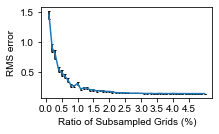

In [27]:
%matplotlib inline

fig1, ax1 = plt.subplots(1, 1, figsize=(8/2.54, 5/2.54))
plt.subplots_adjust(bottom=0.3, wspace=0.5, hspace=0.3)


plt.errorbar(subsampling_test_err_rate*100, result_subsampling, yerr=result_subsampling_error, ecolor='k', capsize=1.)
ax1.set_xlabel('Ratio of Subsampled Grids (%)') 
ax1.set_ylabel('RMS error')
ax1.set_xticks(np.arange(0, 5, 0.5))
# ax1.legend()
# plt.tick_params(labelsize=14,colors=textcol)
plt.tight_layout()
plt.savefig("tex/fig11.eps")


## 露頭データの解析

   distance   Loc  500micron  125micron  63micron
0   6005.01  Loc1   0.001553   0.027791  0.020656
1   7173.01  Loc2   0.006989   0.196721  0.156290
2   8399.01  Loc3   0.033006   0.118912  0.088083
3  12726.01  Loc4   0.102883   0.178082  0.129035
4  17249.01  Loc5   0.326605   0.153008  0.150387
5  27785.01  Loc6   0.002696   0.204115  0.163189
[[  3.57995367e+02   3.61902750e+02   2.06863630e-03   4.20848103e-03
    4.04465517e-03   5.38722038e-03]]


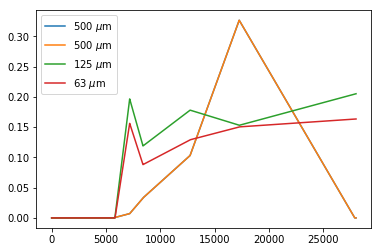

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from keras.models import load_model
from scipy import stats
from scipy.interpolate import interp1d 
import pandas as pd
from pykrige import OrdinaryKriging as OK


#datadir = 'Z:/Documents/PythonScripts/DeepLearningTurbidite/20180419/data/'
#resdir = 'Z:/Documents/PythonScripts/DeepLearningTurbidite/20180419/result/2670/'

datadir = 'Z:/Documents/PythonScripts/DeepLearningTurbidite/20180221/data/'
resdir = 'Z:/Documents/PythonScripts/DeepLearningTurbidite/20180221/result/2558/'


#最初にノーマライズするための元データを取得する
#X_train = np.loadtxt(datadir + 'H_train.txt',delimiter=',')
#X_test = np.loadtxt(datadir + 'H_test.txt',delimiter=',')
#y_train = np.loadtxt(datadir + 'icond_train.txt',delimiter=',')
#y_test = np.loadtxt(datadir + 'icond_test.txt',delimiter=',')


#初期設定
if not "model" in locals(): 
    model = load_model(resdir+'model.hdf5')
gclass = 3
gclass_label = ["500 $\mu$m","125 $\mu$m","63 $\mu$m"]
topodx = 5.
coord_num = int(model.layers[0].input_shape[1]/gclass)

#入力データを[0,1]に正規化するための値を取得する
min_x, max_x = np.loadtxt(datadir + 'x_minmax.txt',delimiter=',')
y_min = np.loadtxt(datadir + 'icond_min.txt',delimiter=',')
y_max = np.loadtxt(datadir + 'icond_max.txt',delimiter=',')

#露頭データを読み込む
#dist_max = 22000. #学習データにおける末端の距離
#outcrop = pd.read_csv('../DeepLearningTurbidite_Fukuda/otadai_no4.csv')
outcrop = pd.read_csv('../DeepLearningTurbidite_Fukuda/GA_naruse_v2.csv')
#outcrop = outcrop.append(pd.DataFrame([[0,'Loc0',0,0,0],[dist_max,'LocE',0,0,0]], columns=outcrop.columns))
outcrop = outcrop.sort_values('distance')
#outcrop['distance'] = outcrop['distance'] - 6005.01
outcrop['distance'] = outcrop['distance'] - 0
#outcrop = outcrop.append(pd.DataFrame([[0,'Loc0',0,0,0,0]], columns=outcrop.columns))
print(outcrop)

#補間の下準備
thick_interp = np.zeros([1,coord_num*gclass])#補間されたサンプル厚さデータ
outcrop_x_id = np.round(outcrop['distance']/topodx).astype(np.int32) #逆解析システムでのサンプリング地点のindex番号
x = np.arange(0,coord_num*topodx,topodx)

#データの補完を行う
#vparams = np.array([[0.035, 10000., 0.001],[0.006, 10000., 0.002],[0.005, 10000., 0.002],[0.035, 10000., 0.001]])
for j in range(gclass):
    f = interp1d(outcrop['distance'],outcrop.iloc[:,j+2], kind="linear", fill_value='extrapolate') #j番目の粒度階の補間関数
    thick_interp[0,coord_num*j:coord_num*(j+1)] = f(x) #補完したデータ
    
    #Kriging による補間
    #okip = OK(outcrop['distance'],np.zeros(outcrop['distance'].shape),outcrop.iloc[:,j+2],variogram_model='power',variogram_parameters=vparams[j,:],)
    #okip = OK(outcrop['distance'],np.zeros(outcrop['distance'].shape),outcrop.iloc[:,j+2],variogram_model='power',)
    #okip.display_variogram_model()
    #ipdata, ipstd = okip.execute('grid',x,np.array([0.]))
    #ipdata = np.squeeze(ipdata)
    #thick_interp[0,coord_num*j:coord_num*(j+1)] = ipdata #補完したデータを代入

#データを正規化する
thick_interp[thick_interp < 0] = 0
thick_interp_norm =  (thick_interp - min_x) / (max_x - min_x)

#逆解析を行う
test_result_outcrop = model.predict(thick_interp_norm)
test_result_outcrop = test_result_outcrop * (y_max - y_min) + y_min

#結果を出力する
print(test_result_outcrop)
np.savetxt('outcrop_result.txt',test_result_outcrop, delimiter=',')
for i in range(len(gclass_label)):
    plt.plot(x,thick_interp[0,coord_num * i:coord_num * (i+1)],label=gclass_label[i])
plt.legend()
plt.show()



# 逆解析した結果の表示

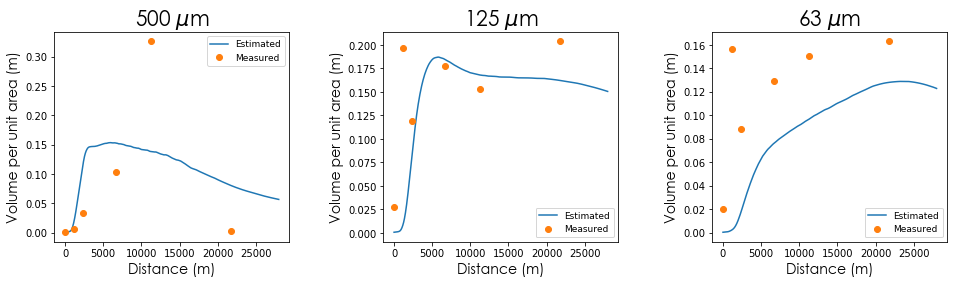

In [31]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

#基本設定
dist_offset = 5000.
dist_max = 28000.
gclass = 3
#gclass_name = ['1.5phi','2.5phi','3.5phi','4.5phi']
gclass_name = ['500micron', '125micron', '63micron']
#gname_tex = ['1.5 $\phi$','2.5 $\phi$','3.5 $\phi$','4.5 $\phi$']
gname_tex = ['500 $\mu$m','125 $\mu$m','63 $\mu$m']
#calcdir = 'Z:/Documents/MATLAB/TCtrainData_forML/TCModel_for_MLTEST/otadai_no5_02/'
calcdir = 'Z:/Documents/MATLAB/TCtrainData_forML/TCModel_for_MLTEST/test_output_otadai07/'

#推定値の読み込み
H1 = np.loadtxt(calcdir + 'H1.txt',delimiter=',')
H2 = np.loadtxt(calcdir + 'H2.txt',delimiter=',')
H3 = np.loadtxt(calcdir + 'H3.txt',delimiter=',')
#H4 = np.loadtxt(calcdir + 'H4.txt',delimiter=',')
Ht = np.loadtxt(calcdir + 'Ht.txt',delimiter=',')
U = np.loadtxt(calcdir + 'U.txt',delimiter=',')
xi = np.loadtxt(calcdir + 'xi.txt',delimiter=',')
x = np.loadtxt(calcdir + 'x.txt',delimiter=',')
x_bed = np.loadtxt(calcdir + 'x_init.txt',delimiter=',')
eta_init = np.loadtxt(calcdir + 'eta_init.txt',delimiter=',')
Ct = np.loadtxt(calcdir + 'Ct.txt',delimiter=',')
time = np.loadtxt(calcdir + 'time.txt',delimiter=',')


#読み込んだデータの整形
#estimated_dep = pd.DataFrame(np.array([x_bed - dist_offset,H1[-1,:],H2[-1,:],H3[-1,:],H4[-1,:]]).T,columns=['distance','1.5phi','2.5phi','3.5phi','4.5phi'])
estimated_dep = pd.DataFrame(np.array([x_bed - dist_offset,H1[-1,:],H2[-1,:],H3[-1,:]]).T,columns=['distance','500micron','125micron','63micron'])
estimated_dep = estimated_dep.query('distance > 0')
estimated_dep = estimated_dep.query('distance < {}'.format(dist_max))

#元のデータの読み込み
#outcrop = pd.read_csv('../DeepLearningTurbidite_Fukuda/otadai_no5.csv')
outcrop = pd.read_csv('../DeepLearningTurbidite_Fukuda/GA_naruse_v2.csv')
#outcrop = outcrop.append(pd.DataFrame([[0,'Loc0',0,0,0],[dist_max,'LocE',0,0,0]], columns=outcrop.columns))
#outcrop = outcrop.sort_values('distance')
outcrop['distance'] = outcrop['distance'] - 6000

#作図
plt.figure(num=None, figsize=(16, 4), facecolor='w', edgecolor='g')
hfont = {'fontname':'Century Gothic'}
plt.subplots_adjust(bottom=0.15, wspace=0.4)

for i in range(gclass):
    plt.subplot(1,gclass,i+1)
    plt.plot(estimated_dep['distance'],estimated_dep[gclass_name[i]],'-', label='Estimated')
    plt.plot(outcrop['distance'], outcrop[gclass_name[i]],'o', label='Measured')
    plt.title(gname_tex[i], size=21,**hfont)
    plt.xlabel('Distance (m)', size = 14, **hfont)
    plt.ylabel('Volume per unit area (m)', size = 14, **hfont)
    plt.legend(fontsize=9)

plt.show()


In [24]:
from scipy.interpolate import interp1d 
import ipdb

ipdb.set_trace()

#各露頭における流速の時間変化を描く
endtime = 20000
delta_t = 100
et = int(endtime / delta_t)
offset = 5000

#補間によって時刻ごとの各露頭地点での流速を求める
U_loc = np.zeros([len(time),len(outcrop['distance'])])
for j in range(len(time)):
    f = interp1d(x[j,:]-offset,U[j,:], kind="linear", bounds_error=False, fill_value=0) #j番目の流速の補間関数
    U_loc[j,:] = f(outcrop['distance'])

#図にプロットする
fig = plt.figure()
for k in range(len(outcrop['distance'])):
    plt.plot(time[:et], U_loc[:et,k], label=outcrop['Loc'][k])
plt.legend()
plt.xlabel('Time (s.)')
plt.ylabel('Velocity (m/s)')
plt.title('Velocity')
plt.show()

#層厚分布をプロットする
plt.figure()
plt.plot(x, Ht)

--Return--
None
> <ipython-input-24-b33c03caedae>(4)<module>()
      3 
----> 4 ipdb.set_trace()
      5 

ipdb> p x
array([  0.00000000e+00,   5.00000000e+00,   1.00000000e+01, ...,
         2.79850000e+04,   2.79900000e+04,   2.79950000e+04])
ipdb> p x.shape
(5600,)
ipdb> p U.shape
(187, 51)
ipdb> q


BdbQuit: 

In [1]:
import matplotlib.animation as animation
%matplotlib

#パラメーター設定
topodx = 5.
deltat= 100.
start_loc = 500.
end_loc = 80000.
start_grid = int(start_loc)
end_grid = int(end_loc/topodx)
etime = H1.shape[0]

fig = plt.figure()
ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312,sharex=ax1)
ax3 = fig.add_subplot(313,sharex=ax1)


ims = []

ax1.plot(x_bed[start_grid:end_grid],eta_init[start_grid:end_grid],'k-')
#ax1.set_title('Flow Height')
#ax2.set_title('Total Concentration')
#ax1.set_xlabel('Distance (m)')
ax1.set_ylabel('Elevation (m)')
ax2.set_ylabel('Concentration (%)')
ax3.set_ylabel('Vol. per unit area (m)')
ax3.set_xlabel('Distance (m)')

#アニメーションの作成
flag_legend = True
for i in range(etime):
    im0 = [ax1.text(0, 200, '$t=${0:.0f}'.format(time[i]))]
    im1 = ax1.plot(x[i,:],xi[i,:],'g-',label='Flow Height')
    im2 = ax2.plot(x[i,:],Ct[i,:]*100,'y-', label='Total Concentration')
    im3 = ax3.plot(x_bed[start_grid:end_grid],H1[i,start_grid:end_grid],'r-', label='500 $\\mu m$')
    im4 = ax3.plot(x_bed[start_grid:end_grid],H2[i,start_grid:end_grid],'c-', label='125 $\\mu m$')
    im5 = ax3.plot(x_bed[start_grid:end_grid],H3[i,start_grid:end_grid],'b-', label='63 $\\mu m$')
    im6 = ax3.plot(x_bed[start_grid:end_grid],Ht[i,start_grid:end_grid],'m-', label='Total thickness')
    if flag_legend:#一回のみ凡例を描画
        ax1.legend(frameon=False)
        ax2.legend(frameon=False)
        ax3.legend(frameon=False)
        flag_legend = False
    ims.append(im0 + im1+im2+im3+im4+im5+im6)

ani = animation.ArtistAnimation(fig, ims, interval=100)

#アニメーションの保存と表示
#ani.save('anim.gif', writer='imagemagick', fps=4)
ani.save('anim.mp4', writer='ffmpeg', fps=20,bitrate=10000)
plt.show()


Using matplotlib backend: Qt5Agg


NameError: name 'H1' is not defined

# 柱状図を作成するスクリプト

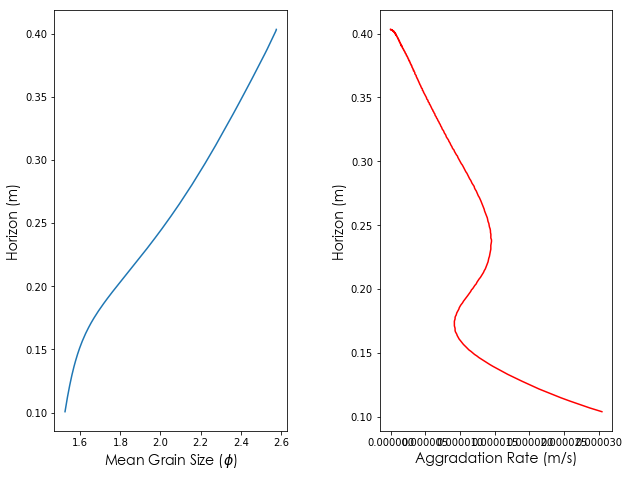

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ipdb


#基本設定
dist_offset = 5000.
dist_max = 28000.
gclass = 3
#gclass_name = ['1.5phi','2.5phi','3.5phi','4.5phi']
gclass_name = ['500micron', '125micron', '63micron']
#gname_tex = ['1.5 $\phi$','2.5 $\phi$','3.5 $\phi$','4.5 $\phi$']
gname_tex = ['500 $\mu$m','125 $\mu$m','63 $\mu$m']
#calcdir = 'Z:/Documents/MATLAB/TCtrainData_forML/TCModel_for_MLTEST/otadai_no5_02/'
calcdir = 'Z:/Documents/MATLAB/TCtrainData_forML/TCModel_for_MLTEST/test_output_otadai07/'

#推定値の読み込み
if "H1" not in locals (): H1 = np.loadtxt(calcdir + 'H1.txt',delimiter=',')
if "H2" not in locals (): H2 = np.loadtxt(calcdir + 'H2.txt',delimiter=',')
if "H3" not in locals (): H3 = np.loadtxt(calcdir + 'H3.txt',delimiter=',')
#if "H4" not in locals (): H4 = np.loadtxt(calcdir + 'H4.txt',delimiter=',')
if "Ht" not in locals (): Ht = np.loadtxt(calcdir + 'Ht.txt',delimiter=',')
if "U" not in locals (): U = np.loadtxt(calcdir + 'U.txt',delimiter=',')
if "xi" not in locals (): xi = np.loadtxt(calcdir + 'xi.txt',delimiter=',')
if "x" not in locals (): x = np.loadtxt(calcdir + 'x.txt',delimiter=',')
if "x_bed" not in locals (): x_bed = np.loadtxt(calcdir + 'x_init.txt',delimiter=',')
if "eta_init" not in locals (): eta_init = np.loadtxt(calcdir + 'eta_init.txt',delimiter=',')
if "Ct" not in locals (): Ct = np.loadtxt(calcdir + 'Ct.txt',delimiter=',')
if "time" not in locals (): time = np.loadtxt(calcdir + 'time.txt',delimiter=',')
    
#基本設定
topodx = 5
loc = 17249
loc_id = round(loc / topodx)
gclass = 3
gclass_phi = [1.0, 3.0, 4.0]
vid = np.array(np.where(Ht[:,loc_id] > 0.1)).T #まだ堆積が起こっていない領域の平均粒径は計算できないため

#柱状図に必要な数値の産出
mean_gsize = (H1[vid,loc_id] * gclass_phi[0] + H2[vid,loc_id] * gclass_phi[1] + H3[vid,loc_id] * gclass_phi[2])/Ht[vid,loc_id]
sed_vel = ((Ht[vid[2:], loc_id] - Ht[vid[:-2],loc_id]) / (time[vid[2:]] - time[vid[:-2]]))
#ipdb.set_trace()

#柱状図の描画
plt.figure(num=None, figsize=(10, 8), facecolor='w', edgecolor='g')
hfont = {'fontname':'Century Gothic'}
textcol='k'
plt.subplots_adjust(bottom=0.15, wspace=0.4)

plt.subplot(1,2,1)
plt.plot(mean_gsize,Ht[vid,loc_id])
plt.xlabel("Mean Grain Size ($\phi$)",color=textcol,size=14,**hfont)
plt.ylabel("Horizon (m)",color=textcol,size=14,**hfont)

plt.subplot(1,2,2)
plt.plot(sed_vel, Ht[vid[1:-1],loc_id],'r')
plt.xlabel("Aggradation Rate (m/s)",color=textcol,size=14,**hfont)
plt.ylabel("Horizon (m)",color=textcol,size=14,**hfont)
plt.savefig("column.svg")
plt.show()

    


# 作業メモ


### 2017/8/18
- 斜面も変数とした6変数のフォワードモデルを用いてトレーニングデータ（サンプルサイズ1000）を作り，実験をした

- validation split = 0.2

- Adadelta, Adam, SGD（学習率0.02, momentum 0.9, nesterovあり）では，バッチサイズに関わらずSGDが最も成績が良い（ただしエポック数10）

- バッチサイズは4, 8, 16, 32, 64を試したところ，8が最も成績が良い（ただしエポック数10）

- SGD, バッチサイズ16でエポック数300にしたところ，過学習がみられた．

- Dropout(0.5) を隠しレイヤーに入れてみると，不連続にmseが減少した．

    - エポック数10の時は過学習は見られない

    - エポック数500で実験を行うと，mse=0.3程度から全く学習が進まなくなった（エポック数15で打ち切り）

    - バッチサイズ16にしてやり直し→Epoch11あたりから急激に学習が進む（0.3から0.07へ）

    - Dropoutを入れると過学習は避けられているが学習の進行が遅く，しかも断続的に進む

    - 最終的にmseは0.0236となった．overfittingは全くないものの，あまり成績が良くない

- SGD, バッチサイズ8，Dropoutなしで500エポックをやってみる．→mse0.007だが過学習（トレーニングデータでは6.03e-04）

### 2017/8/19
- SGD, バッチサイズ8，Dropout（0.5）を一つ目の隠し層だけに入れてみる．→mse0.0123でやや過学習（トレーニングデータでは0.0060）
- この後やるべきこと
    - 誤差の計算
    - 復元された値で数値計算をしてみて，真値からどのくらい流速などの条件がずれているのか3地点程度でチェックする
    - 入力値にノイズを加えてみて，結果のロバストさを調べる
    - 補外はどの程度できるのかチェックする
    - トレーニングデータの量はどの程度が適切なのか→トレーニングデータを5000くらい生成してみること
    
### 2017/8/20
- Adam, バッチサイズ8，Dropout（0.5）を一つ目と二つ目の隠し層にいれてみて，1000エポック計算してみる→mse0.0112程度．過学習はほとんどない．

### 2017/8/22
- トレーニングデータを増やしてみる．1500×4で6000個のデータを作成する．計算条件：計算終了は20000秒，流れの初期高さ100-800，初期長さ100-800，濃度は3粒径（500, 125, 63 micron）それぞれ1-0.01%，勾配は0-0.5%

### 2017/9/1
- 現状でベストな設定：
	- SGD, lr=0.02, momentum=0.9, nesterov=True
	- metrics=["mean_squared_error"]
	- batch_size = 8
	- epoch = 1000
- ニューラルネットワークの構造
	- 入力層21000→隠し層（1）3200→隠し層（2）1000→隠し層（3）200→隠し層（4）50→出力層6
	- 活性化関数はすべてReLU
- 今日の実験：ネットワークの層数を変えてみる（epoch数10で実験）
	- そのまま→mse0.03156
	- 隠し層（1）を消す→mse0.0309
		- 隠し層（1）がない方が成績が良い！勾配消失？
	- 隠し層（２）を消す→0.0318
		- 若干成績が落ちるが，それほど変わりはない
	- 隠し層（３）を消す→0.0318
		- 若干成績が落ちるが，それほど変わりはない

### 2017/9/14
- GPU（GeForce GTX 1050 Ti）をインストール
- tensorflow-gpu0.12をインストール(CUDA8.0&cuDNN6.0)
- 速度が十倍以上に向上し，CPUはほぼフリー！
- ちょっと実験：ネットワークの総数を変えてみる（epoch数10で実験）
	- 隠し層（2）と（３）を消してみる→0.0489
		- 成績が大幅に落ちた．どうやら隠し層は３つ必要らしい
- 新規ニューラルネットワークの構造
	- 入力層21000-Dropout(0.5)→隠し層（１）1000→隠し層（２）200→隠し層（３）50→出力層6
		- そのまま→mse0.035
		- Dropout(0.5)を消してみると，0.035, 0.028, 0.028でoverfittingなしのときもあるがoverfitting気味の時もある
		- 隠し層（１）にDropout(0.5)を入れてみると，0.035, 0.0365でoverfittingなし
- 地質学会向け暫定版NNの構造を以下の通りとする
	- 入力層21000→隠し層（１）1000-Dropout(0.5)→隠し層（２）200→隠し層（３）50→出力層6
	- epoch数300で実行→mse0.005程度
	- SGD（学習率0.02, momentum 0.9, nesterovあり）でバッチ数16にしたところ，結果が向上した
	- トレーニングデータ数を1000，2000，3000，4000，4500と変化させたところ，1000から3000ではmseに大きな向上が見られたが，それ以降はあまり変化が無い
	- 今のところ0.005程度が最高記録（データ数4500の場合）

### 2018/1/17
- トレーニングデータを作り直した（現在計算中）．
    - 計算終了時刻を100000秒（約28時間）として，計算ドメインの大きさを100 kmにしたので，一応すべての堆積物が落ちるはず．
- 現状でそろったデータ数1200にてテスト中
- 改良点
    - レイヤー数を5層-8層で変化させて検討中（5層が今のところベスト）
     -ユニット数は2000で統一（おそらく冗長だが気にしない）
    - SGD(learning rate 0.03, decay rate 0.4e-04, momentum 0.9, nesterovあり）バッチ数16が今のところベスト
    - kernel initializerをgrolot_uniformに変更したところ，結果が劇的に向上した．
    - Drop outは最初の隠しレイヤーに0.5で入れている．他のレイヤーに入れると学習が進まない．

### 2018/1/18
- 昨日に引き続き検討中．
- レイヤー数は5層がベスト
- drop out（0.5）は最後のレイヤーを除くすべてのレイヤーへ入れると過学習が起こらない．
- SGDの(learning rate 0.03, decay rate 0.4e-04）とSGD(learning rate 0.02, decay rate 0）はほとんど互角
- Epochを500から1000にしてみようかな．
- 今のところmseのベストは0.0161

### 2018/1/19
- 昨日に引き続き検討中
- Adadeltaはまあまあ（0.021)．Adamは全然ダメ．
- Adamのlearning rateを変えてみる．⇒全然ダメ
- SGD(learning rate 0.03, decay rate 0.4e-04）でepoch1000にしたところ，最高記録を達成（0.0138）．このあたりが限界か？
- SGD(learning rate 0.02, decay rate 0）でepoch1000にしてみよう．最高記録を達成（0.0120）．
- SGD(learning rate 0.02, decay rate 0）でepoch2000にしてみよう．最高記録を達成（0.009986)．
- SGD(learning rate 0.02, decay rate 0) batch 8でepoch2000⇒いまいち（0.066)．
- SGD(learning rate 0.03, decay rate 1.0e-05) batch16でepoch2000→ほぼ最高記録と同等（0.0107）．ここが限界だろう．

### 2018/1/24
- SGD(learning rate 0.03, decay rate 1.0e-05) batch32でepoch2000→最高記録（0.00957）．まだいけるかもしれない．
- SGD(learning rate 0.02, decay rate 0) batch32でepoch2000→最高記録とほぼ同等（0.00972）．まだいけるかもしれない．
- SGD(learning rate 0.02, decay rate 0) batch64でepoch2000→最高記録とほぼ同等（0.00985）．このあたりが限界かな．

### 2018/1/25
- レイヤーを一つ増やしてみた（隠しレイヤーが６つ）．SGD(learning rate 0.02, decay rate 0) batch32でepoch2000→最高記録とほぼ同等（0.00985）．つまり特に向上は見られない．
- レイヤーを一つ減らしてみた（隠しレイヤーが４つ）．SGD(learning rate 0.02, decay rate 0) batch32でepoch2000→最高記録達成！（0.00827）
- さらにレイヤーを一つ減らす（隠しレイヤーが３つ）．SGD(learning rate 0.02, decay rate 0) batch32でepoch2000→0.00939．ちょっと成績がさがった．隠しレイヤーは4つがベストらしい．
- 隠しレイヤー4つでSGD(learning rate 0.03, decay rate 1.0e-05) batch32，epoch2000→0.00860．ほぼ最高記録と同等だが，learning rateはどうやら固定した方がいいらしい．
- 隠しレイヤー4つでadadeltaを試してみる．batch32，epoch2000→0.0118．大してよくない．トレーニングデータでは0.0066なので，完全にオーバーフィッティング

### 2018/1/29
- 隠しレイヤー４つ．SGD(learning rate 0.02, decay rate 0) batch32でepoch2000→0.00848．やはりこの設定がコンスタントに成績が良い．
- 残渣をチェック．
    - 残渣の平均値
[ -7.63810426e+00  -1.88151649e+01  -4.36880991e-04  -2.40537440e-04
  -6.26971886e-04   1.29950743e-04]
    - 残渣の2σ
[  5.58839758e+01   7.95840009e+01   1.22758221e-03   1.33981768e-03
   1.85698892e-03   6.17234839e-04]
    - シャピロ・ウィルク検定のp値は以下の通り→$S_l$以外は正規分布とは言えない．→ノンパラメトリックな誤差推定が必要．

|variable|p|
|---|---|
|$l_0$|0.0022262868005782366|
|$H_0$|3.0351007808349095e-05|
|$C_1$|0.0265838373452425|
|$C_2$|0.01678871177136898|
|$C_3$|7.528178684879094e-06|
|$S_l$|0.30633744597435|

- 計測値に誤差を加えた場合のシミュレーションを行った．正規乱数を発生させ，2σが計測値のe%になるようにスケーリングして計測値に足し合わせた．その結果，逆解析が極めてロバストであることが証明された．e=100%で誤差を加えても，ほとんど影響は見られない．500%くらいでようやく大きな誤差がみられるようになる．素晴らしい！
- リサンプリングでは，1%以下になると急激に成績が悪化する．1 km程度の頻度でデータが必要．

### 2018/2/19
- 大田代層への適用．
    - >2.5 phi = 500 $\mu$m, 2.5--3.5 phi = 125 $\mu$m, <3.5 phi = 63 $\mu$m として計算．含泥率も考慮（=63 $\mu$mとみなした）
    - 東日傘層の分布東端を海底谷末端と解釈して，そこからの各露頭の距離をx座標値として用いた．
    - 粒度分布を鉛直平均し，層厚をかけて，粒径別面積当たり堆積量を計算した．
    - 露頭間のデータ・計測区間外の対応
        -線型補間・補外（0と7000 m地点で厚さゼロ）
    - 結果：3.56160629e+02   3.51775348e+02   4.42300827e-03   4.75855211e-03    6.28440559e-03   1.19929761e-04
        - 何となくそれっぽいかな？
    - 先ほどは計算間違い（dx = 5 mのところ10 mとして計算していました）．ただしくは下記の通り：
        - $l_0$: 4.42753816e+02, $H_0$: 4.68304175e+02, $C_1$: 1.21124697e-03, $C_2$: 4.10763268e-03, $C_3$: 5.36788050e-03, $S_l$: 3.21568817e-03
    - これはうまくいっていない．原因は，補外？→学習やり直しをやってみよう；補間？→Krigingを試してみよう；学習データの初期値範囲が悪い？→学習データの生成をやり直す必要がある

### 2018/2/20
- 昨日の続きで手法を大田代層へ適用
    - 古流向方向に投影することで露頭間の距離を決める
    - 補間方法をKrigingに変更
    - 結果：$l_0$: 4.51542318e+02, $H_0$: 4.64720690e+02, $C_1$: 6.80109105e-04, $C_2$: 3.61492358e-03, $C_3$: 4.47290092e-03, $S_l$:2.26792350e-03
- 間違えた！データをノーマライズするのを忘れてた．やり直し．
- 結果（線型補間）：$l_0$:3.70987403e+02, $H_0$:3.61791265e+02, $C_1$:1.13563218e-03, $C_2$:2.82871366e-03, $C_3$:  3.09152468e-03, $S_l$:5.43223023e-03
- 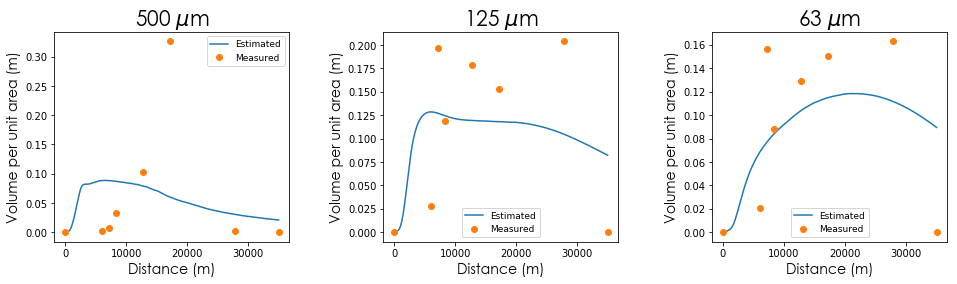
- クリギングでPowerモデルをつかった場合
- 結果（Kriging (power)）：3.68457890e+02   3.58259517e+02   1.28700369e-03   2.90782148e-03    3.12362566e-03   5.45903862e-03
- あまり変わらない．

### 2018/2/21
- 学習のやり直し．分析対象の最初の地点から最後の地点までの区間で学習データを抽出し，学習する．補外が必要なくなる．
- 昨日の復元パラメーターで数値計算をやってみる．どの程度適合するか．
- わかったこと：500 $\mu$m のピークは真っ当なやり方では再現できない．
    - 今のところ，0-22000の区間で逆解析すると，ピーク自体は再現できる（しかしデータは6005-27000の区間なのでインチキ）
        - このデータの計算結果はotadai06に保存されている．
    - 6005-27000のデータを0-22000にマップしても，0-27000にマップしても（上流は補外を使う），500 $\mu$mのピークは出てこない．おそらく，22000-27000区間の低い層厚の影響が出てしまうのだろう．
    - どうすれば？たぶん，中尾の3粒径区分が間違い．500, 125, 63では，極端に粗すぎる．天然のデータでは300 $\mu$m付近に多くの堆積物が含まれているのに，この粒度区分ではその粒径が500 $\mu$mの階級に丸められてしまう．

### 2018/2/26
- トレーニングデータ生成のやり直し．粒径区分を1.5phi, 2.5phi, 3.5phi, 4.5phiの4階級に切りなおした．計算時間を最大で120000秒とした．

### 2018/4/03
- 4階級のトレーニングデータで学習のやり直し．データ数は1728個．世代数を4000にした．計算時間は5時間ぐらい．

### 2018/4/5
- トレーニングデータの交叉検証ではval_loss: 0.0067なのに，選り分けておいたテストデータではloss: 0.016なのはなぜか．独立データでは誤差が3倍になってしまう．過学習？しかし，トレーニングデータ内の交叉検証では問題がないのだが．
- テストデータを200に増やしてみよう．

### 2020/10/13
- 論文化に向けて作業中．4階級のトレーニングデータが3000になるように少し増やした．世代数は8000でも若干不足．トレーニングデータ数は2000以下だと過学習がおこる．2500からは大丈夫．レイヤー数を改めてしらべる．５レイヤー(0.0034)よりも4レイヤー(0.0030)の方が若干成績がよい．3レイヤーはだめ（0.0040）．

# To do list

- 誤差の計算
    - Jackknife法による誤差の検定

- 現実のデータへの適用
    - 計測区間外の扱いをどうするか．
        - 補外？計測区間だけを学習したNNをつくるか？

- 復元された値で数値計算をしてみて，真値からどのくらい流速などの条件がずれているのか露頭計測地点でチェック
    - 各地点での流速の時間変化（作成済み）＋濃度の時間変化（これから）＋堆積速度の時間変化
    - 各地点での粒度分布に入力値の粒度分布を重ねる
    - 各地点での柱状図（平均粒径の垂直変化）＋入力値の柱状図＋流速変化＋濃度変化

- トレーニングデータの量はどの程度が適切なのか→トレーニングデータを5000くらい生成してみること

- Forward Modelに濃度補正を入れる？4eqにする？＋bedloadを入れる
